In [1]:
import dask
import dask.bag as db
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

import pandas as pd
from pandas import DataFrame as df
import re
import html
from datetime import datetime
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

dask.config.set(scheduler='multiprocessing')

%matplotlib inline

# Acknowledgements and Docs

Various functions taken and modified from https://sigdelta.com/blog/dask-introduction/ for formatting

Dataset:
* **dataset_raw** : XML Form
* **dataset_parquet** : XML to Parquet
* **dataset_tags** : Serialized unique tags
* **dataset_tag_matrix** : Boolean table for filtering by tag using top 25 tags

# Formatting
## Initial Read

In [2]:
posts_xml = db.read_text('D:\PROJECT\dataset_raw\posts\posts.xml', encoding='utf-8', blocksize=1e8)

In [3]:
posts_rows = posts_xml.filter(lambda line: line.find('<row') >= 0)

## Helper Functions

In [4]:
def extract_posts_columns(line):
    l = html.unescape(line)
    row = {
        'id': extract_column_value(l, 'Id', int),
        'post_type_id': extract_column_value(l, 'PostTypeId', int),
        'accepted_answer_id': extract_column_value(l, 'AcceptedAnswerId', int),
        'score': extract_column_value(l, 'Score', int),
        'title': extract_column_value(l, 'Title', str),
        'tags': extract_column_value(l, 'Tags', str),
        'body': extract_column_value(l, 'Body', str)
    }
    return row


def extract_column_value(line, col_name, cast_type=str):
    pattern_tpl = r'{col}="([^"]*)"'
    pattern = pattern_tpl.format(col=col_name)
    match = re.search(pattern, line)

    if cast_type == int:
        null_value = 0
    else:
        null_value = None

    return cast_type(match[1]) if match is not None else null_value

## Format to Dataframe 

In [5]:
posts = posts_rows.map(extract_posts_columns).to_dataframe()

In [ ]:
with ProgressBar():
    posts.repartition(npartitions=100)\
        .to_parquet('D:\PROJECT\dataset_parq\posts.parq', engine='fastparquet', compression='snappy')

In [13]:
java = posts.query("tags.str.contains('java', na=False)")

In [14]:
c = posts.query("tags.str.contains('c#', na=False)")

In [15]:
python = posts.query("tags.str.contains('python', na=False)")

## Write Parsed Frame to Parquet

In [16]:
with ProgressBar():
    print('Writing Java...')
    java.repartition(npartitions=100)\
        .to_parquet('D:\PROJECT\dataset_select\java.parq', engine='fastparquet', compression='snappy')
with ProgressBar():
    print('Writing Python...')
    python.repartition(npartitions=100)\
        .to_parquet('D:\PROJECT\dataset_select\python.parq', engine='fastparquet', compression='snappy')
with ProgressBar():
    print('Writing C#...')
    c.repartition(npartitions=100)\
        .to_parquet('D:\PROJECT\dataset_select\c.parq', engine='fastparquet', compression='snappy')    

Writing Java...
[########################################] | 100% Completed | 27min 12.0s
Writing Python...
[########################################] | 100% Completed | 27min  3.9s
Writing C#...
[########################################] | 100% Completed | 26min  2.1s


## Exploration

In [7]:
posts = dd.read_parquet('D:\PROJECT\dataset_parq\posts.parq', engine='fastparquet')

In [33]:
with ProgressBar():
    posts_count = posts.groupby(posts.creation_date.dt.year)\
        .id.count()\
        .to_frame()\
        .rename(columns={'id': 'count'})\
        .compute()
posts_count


[########################################] | 100% Completed | 31.5s


,count
creation_date,
2008,57802
2009,342158
2010,691588
2011,1191477
2012,1631510
2013,2040534
2014,2144535
2015,2200729
2016,2204101


In [6]:
with ProgressBar():
    posts_count = posts.groupby(posts.post_type_id)\
        .id.count()\
        .to_frame()\
        .rename(columns={'post_type_id': 'count'})\
        .compute()
posts_count


[########################################] | 100% Completed | 30min 38.1s


,id
post_type_id,
1,21641802
2,32199928
3,167
4,53824
5,53824
6,334
7,5
8,2


In [17]:
with ProgressBar():
    posts_count = python.groupby(python.post_type_id)\
        .id.count()\
        .to_frame()\
        .rename(columns={'post_type_id': 'count'})\
        .compute()
posts_count


[########################################] | 100% Completed | 26min 59.2s


,id
post_type_id,
1,1965461


In [39]:
print("Total x, y pairs: ", np.sum(posts_count['count']))

Total x, y pairs:  21641896


## Further Cleaning

In [14]:
def extract_indv_tags(val):
    return [v.strip(">") for v in str(val).split('<')][1:]
with ProgressBar():
    posts['tags'] = posts['tags'].map(extract_indv_tags).compute()

[########################################] | 100% Completed | 34min 57.7s


In [12]:
posts

,post_type_id,accepted_answer_id,creation_date,score,view_count,title,tags,body
npartitions=920,,,,,,,,
4,int64,int64,datetime64[ns],int64,int64,object,object,object
155884,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
69038780,...,...,...,...,...,...,...,...
69061027,...,...,...,...,...,...,...,...


In [13]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

def boolean_df(item_lists, unique_items):
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        print(item)
        bool_dict[item] = item_lists.apply(lambda x: item in x, meta=('tags', 'bool')).compute()
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

In [ ]:
with ProgressBar():
    unique_items = to_1D(posts['tags']).value_counts()

In [ ]:
subset = unique_items.head(25)
subset

In [119]:
subset.index

Index(['javascript', 'java', 'python', 'c#', 'php', 'android', 'html',
       'jquery', 'c++', 'css', 'ios', 'mysql', 'sql', 'r', 'node.js', 'arrays',
       'asp.net', 'c', 'reactjs', 'ruby-on-rails', 'json', '.net',
       'sql-server', 'swift', 'python-3.x'],
      dtype='object')

TypeError: plot got an unexpected keyword argument 'x'

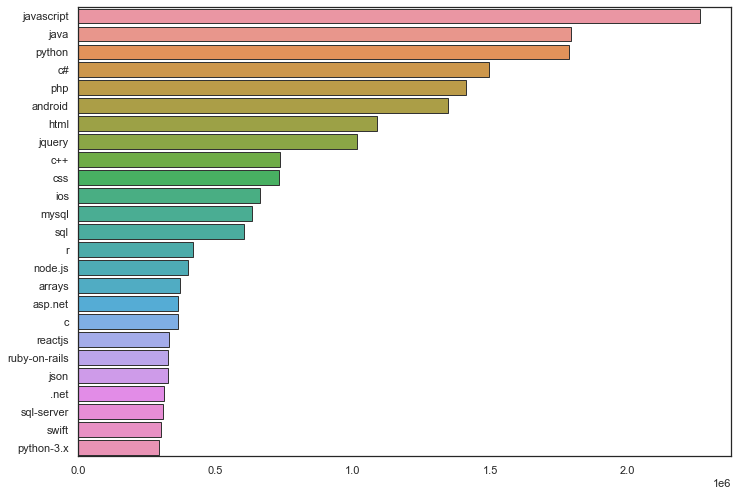

In [127]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
sns.barplot(x=subset.values, y=subset.index, edgecolor=".2")
plt.plot(x=1.5*10**6, color='r')
plt.show()

In [ ]:
with open('unique_tags.pkl', 'wb') as f:
    pickle.dump([k for k in unique_items.keys()], f)

In [9]:
with open('D:/PROJECT/dataset_tags/unique_tags.pkl', 'rb') as f:
   tags = pickle.load(f)[:25]


## Tag Matrix for Filtering

In [14]:
tag_matrix = boolean_df(posts['tags'], tags)

javascript
java
python
c#
php
android
html
jquery
c++
css
ios
mysql
sql
r
node.js
arrays
asp.net
c
reactjs
ruby-on-rails
json
.net
sql-server
swift
python-3.x


In [18]:
tmp = dd.from_pandas(tag_matrix, npartitions=30)

In [20]:
with ProgressBar():
    tmp.to_parquet('D:/PROJECT/dataset_tag_matrix/tag.parq', engine='fastparquet', compression='snappy')

[########################################] | 100% Completed | 12.6s


## Testing Filters in Dask

In [11]:
tag_matrix = dd.read_parquet('D:\PROJECT\dataset_tag_matrix/tag.parq', engine='fastparquet')

In [38]:
tag_matrix[tag_matrix['javascript']==True]

,javascript,java,python,c#,php,android,html,jquery,c++,css,ios,mysql,sql,r,node.js,arrays,asp.net,c,reactjs,ruby-on-rails,json,.net,sql-server,swift,python-3.x
npartitions=30,,,,,,,,,,,,,,,,,,,,,,,,,
0,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
785,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23009,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27157,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [11]:
with ProgressBar():
    posts = posts.reset_index().set_index('id')

[########################################] | 100% Completed | 32min 56.5s


In [10]:
del tag_matrix

In [16]:
posts.loc[tag_matrix['javascript']==True]

,index,post_type_id,accepted_answer_id,creation_date,score,view_count,title,tags,body
npartitions=951,,,,,,,,,
0,int64,int64,int64,datetime64[ns],int64,int64,object,object,object
4,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
69038780,...,...,...,...,...,...,...,...,...
69061027,...,...,...,...,...,...,...,...,...
